In [42]:
# необходимые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
# загружаем наши данные по продажам за период 13/03/2021 - 21/04/2022
df = pd.read_csv('C:\\Users\\HP\\Desktop\\Power BI AKZ\\orders.csv', sep=';')
df.head(0)

,order_id,order_number,create_date,product_id,product_name,product_price,summ,type_order,client_name,client_surname,...,fin_potok,utm_source,utm_medium,utm_campaign,utm_content,utm_term,utm_referrer,userId_YM,userId_GA,roistat_visitor


In [3]:
df.columns

Index(['order_id', 'order_number', 'create_date', 'product_id', 'product_name',
       'product_price', 'summ', 'type_order', 'client_name', 'client_surname',
       'client_email', 'client_phone', 'client_city', 'client_address',
       'client_index', 'client_comment', 'admin_comment', 'partner_id',
       'status', 'payment_id', 'payment_name', 'payment_date',
       'installment_ID', 'fin_potok', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_content', 'utm_term', 'utm_referrer', 'userId_YM',
       'userId_GA', 'roistat_visitor'],
      dtype='object')

In [4]:
# удалим ненужные колонки
df = df.drop(['order_id', 'order_number', 'create_date', 'product_id', 'product_name', 'product_price', 'type_order', 'client_name', 'client_surname', 'client_city', 'client_address',
       'client_index', 'client_comment', 'admin_comment', 'partner_id', 'status', 'payment_id', 'payment_name', 'installment_ID', 'fin_potok', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_content', 'utm_term', 'utm_referrer', 'userId_YM', 'userId_GA', 'roistat_visitor'], axis=1)

In [5]:
# приведем текст в формат даты
df['date'] = pd.to_datetime(df['payment_date'], format='%d.%m.%Y %H:%M:%S')

In [6]:
# находим частоту заказов frequency
frequency = df['client_email'].value_counts()

In [7]:
# создадим датасет клиентов по частоте покупок
df_frequency = pd.DataFrame({'client_email':frequency.index, 'frequency':frequency.values})
df_frequency.head(0)

,client_email,frequency


In [8]:
# посмотрим статистику по датасету
df_frequency.describe(percentiles = [0.20, 0.40, 0.60, 0.80, 0.90, 0.99])

# видим, что средняя частота покупок одним клиентом за данный период - 1,7, минимум - 1 заказ, максимум - 16 заказов.
# 60% клиентов делали заказы не более 1 раза.

,frequency
count,12666.000000
mean,1.743565
std,1.833691
min,1.000000
20%,1.000000
40%,1.000000
50%,1.000000
60%,1.000000
80%,2.000000
90%,4.000000


In [9]:
# находим общую сумму оплат по каждому клиенту (LTV)
df_sum = df.groupby('client_email').sum().groupby(level=[0]).cumsum()

In [10]:
# переименуем колонку с суммой, чтобы не запутаться
df_sum.rename(columns = {'summ': 'total_value'}, inplace = True)
df_sum.head(0)

,total_value
client_email,


In [11]:
# найдем даты последних заказов по каждому клиенту
df_last_order = df.sort_values('date').groupby('client_email').last()

In [12]:
# переименуем колонку с датой
df_last_order.rename(columns = {'date': 'last_date'}, inplace = True)
df_last_order.head(0)

,summ,client_phone,payment_date,last_date
client_email,,,,


In [13]:
# удалим из датафрейма не нужную нам колонку с суммой
df_last_order = df_last_order.drop(['summ'], axis=1)

In [14]:
# объединяем два датасета - с LTV клиента и датой его последнего заказа по client_email
df_merge = df_last_order.merge(df_sum, on='client_email')
df_merge.head(0)

,client_phone,payment_date,last_date,total_value
client_email,,,,


In [15]:
df_merge.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])
# существует значительная разница между максимальной суммой всех заказов одного покупателя и 99% остальных клиентов

,total_value
count,12666.000000
mean,7596.674562
std,5710.544383
min,50.000000
25%,4000.000000
50%,6490.000000
75%,7735.000000
90%,13990.000000
95%,18960.000000
99%,32368.800000


In [16]:
# найдем клиентов с общей суммой всех заказов свыше 32368,8 выделим в отдельный RFM сегмент most_buy 
most_buy = df_merge[df_merge['total_value'] > 32368.80]
most_buy.head(0)

,client_phone,payment_date,last_date,total_value
client_email,,,,


In [17]:
# количество таких клиентов - 127 (1% от всех).
most_buy.shape

(127, 4)

In [18]:
# отсортируем датасет по последней дате заказа, чтобы выделить клиентов, которых нужно вернуть.
most_buy = most_buy.sort_values(by='last_date')

In [19]:
# импортируем в файл для дальнейшей работы с этими клиентами
most_buy.to_csv('most_buy.csv')

In [20]:
# добавим в объединенный датасет сегодняшнюю дату
today = '2022-04-21'
df_merge['current_date'] = today
df_merge['current_date'] = pd.to_datetime(df_merge['current_date'], format='%Y-%m-%d')

In [21]:
# посчитаем сколько дней назад последний раз был заказ у клиента, так мы сможем найти клиентов в оттоке.
df_merge['churn_time'] = df_merge['current_date'] - df_merge['last_date']

In [22]:
df_merge.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.99])

,total_value,churn_time
count,12666.000000,12666
mean,7596.674562,164 days 01:19:31.626322364
std,5710.544383,111 days 17:14:29.600725006
min,50.000000,-1 days +06:59:36
25%,4000.000000,70 days 10:59:17.250000
50%,6490.000000,144 days 02:54:46
75%,7735.000000,261 days 03:04:10
90%,13990.000000,326 days 10:47:33.500000
99%,32368.800000,403 days 09:47:46.800000
max,80300.000000,447 days 14:55:16


In [23]:
# объединим датасет с частотой покупок
df_merge_frequency = df_merge.merge(df_frequency, on='client_email')
df_merge_frequency.head(0)

,client_email,client_phone,payment_date,last_date,total_value,current_date,churn_time,frequency


In [24]:
# найдем клиентов, которые последний раз покупали более 6 месяцев назад, отсортируем по убыванию суммы покупок
# таких клиентов - 5291 чел, 42%
churn = df_merge_frequency[df_merge_frequency['churn_time'] > '180 days'].sort_values(by='total_value', ascending=False)
churn = churn.drop(['current_date'], axis=1)

In [25]:
# импортируем в файл для дальнейшей работы с этими клиентами
churn.to_csv('churn.csv')

In [26]:
# переходим к RFM-сегментации, добавляем коэффициент Monetary по сумме покупок (M):
# 3 — маленькая сумма (до 6990 руб.);
# 2 — средняя сумма (до 18960 руб.);
# 1 — большая сумма (свыше 18960 руб.).
df_merge_frequency['M'] = [2 if x > 6990 else 3 for x in df_merge_frequency['total_value']]
df_merge_frequency.loc[df_merge_frequency['total_value'] > 18960, 'M'] = 1
df_merge_frequency.head(0)

,client_email,client_phone,payment_date,last_date,total_value,current_date,churn_time,frequency,M


In [27]:
# рассчитаем индекс частоты заказов Frequency (F):
# 3 — покупает редко (1 раз в год);
# 2 — покупает нечасто (2-4 заказа в год);
# 1 — покупает часто (от 5 заказов).
df_merge_frequency['F'] = [2 if x >= 2 else 3 for x in df_merge_frequency['frequency']]
df_merge_frequency.loc[df_merge_frequency['frequency'] > 4, 'F'] = 1
df_merge_frequency.head(0)

,client_email,client_phone,payment_date,last_date,total_value,current_date,churn_time,frequency,M,F


In [28]:
# рассчитаем индекс давности заказа Recency (R):
# 3 — спящие клиенты (больше года назад);
# 2 — давние клиенты (от 6 месяцев до года);
# 1 — недавние клиенты (от 0 до 6 месяцев).
delta3 = timedelta(days=365, hours=0, minutes=0) 
delta2 = timedelta(days=180, hours=0, minutes=0)
delta1 = timedelta(days=0, hours=0, minutes=0)

In [29]:
df_merge_frequency['R'] = [2 if x > delta2 else 1 for x in df_merge_frequency['churn_time']]
df_merge_frequency.loc[df_merge_frequency['churn_time'] > delta3, 'R'] = 3
df_merge_frequency.head(0)

,client_email,client_phone,payment_date,last_date,total_value,current_date,churn_time,frequency,M,F,R


In [30]:
# импортируем данные в файл для дальнейшего использования для целей маркетинга
df_rfm = df_merge_frequency.drop(['current_date'], axis=1) 
df_rfm.to_csv('rfm_analysis.csv')

In [43]:
# создадим сводную таблицу по кол-ву клиентов в каждрй категории (комбинации  индекса RFM)
# сначала создадим столбец с комбинацией
df_rfm['R'] = df_rfm['R'].astype(str)
df_rfm['F'] = df_rfm['F'].astype(str)
df_rfm['M'] = df_rfm['M'].astype(str)
df_rfm['RFM'] = df_rfm['R'] + df_rfm['F'] + df_rfm['M']

In [46]:
df_pivot = df_rfm.pivot_table(index='RFM', values='client_email', aggfunc='count')
df_pivot

,client_email
RFM,
111,498
112,552
121,108
122,1067
123,417
131,9
132,374
133,4505
221,16


<AxesSubplot:title={'center':'Количество клиентов в каждом сегменте RFM'}, xlabel='RFM', ylabel='client_email'>

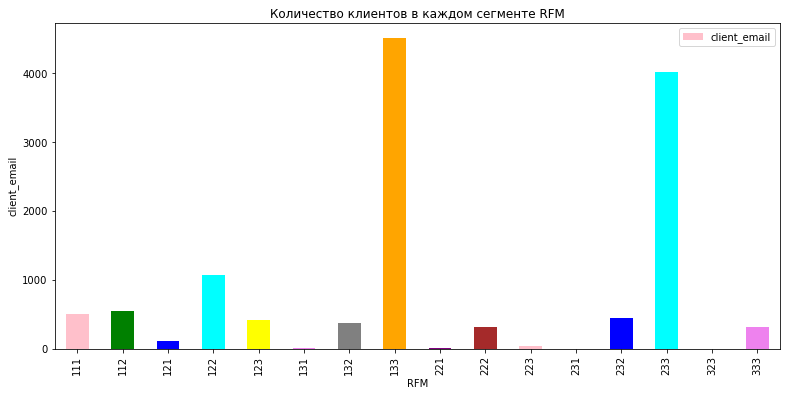

In [48]:
# Визуализируем нашу сводную таблицу, чтобы увидеть наглядно какое кол-во клиентов есть в каждом сегменте
from pylab import rcParams
rcParams['figure.figsize'] = 13,6 #увеличим дефолтный размер графиков

df_pivot.plot(kind='bar', 
            title='Количество клиентов в каждом сегменте RFM',
            xlabel='RFM',
            ylabel='client_email',
            color=[['pink', 'green', 'blue', 'cyan', 'yellow', 'violet', 'grey', 'orange', 'purple', 'brown']])
# Видим, что самая многочисленная категория - комбинация 133 - недавние разовые клиенты с низким чеком

In [40]:
# выделим сегмент attention - крупные клиенты с датами последних заказов от 6 месяцев до года, для работы с оттоком
attention_raw = df_rfm.loc[df_rfm ['M'] == 1]
attention = attention_raw.loc[attention_raw ['R'] == 2]
attention.head(0)

,client_email,client_phone,payment_date,last_date,total_value,churn_time,frequency,M,F,R


In [41]:
# импортируем в файл для дальнейшего использования
attention.to_csv('attention.csv')

In [42]:
# найдем самых крупных и верных клиентов, таких 498 (4%)
top_raw = df_rfm.loc[df_rfm ['M'] == 1]
top_raw_1 = top_raw.loc[top_raw ['R'] == 1]
top = top_raw_1.loc[top_raw_1 ['F'] == 1]
top.head(0)

,client_email,client_phone,payment_date,last_date,total_value,churn_time,frequency,M,F,R


In [43]:
# найдем самых верных клиентов, которые покупают не часто, но на большую сумму 
top2_raw = df_rfm.loc[df_rfm ['M'] == 1]
top2_raw_1 = top_raw.loc[top_raw ['R'] == 1]
top2 = top_raw_1.loc[top_raw_1 ['F'] == 2]
top2.head(0)

,client_email,client_phone,payment_date,last_date,total_value,churn_time,frequency,M,F,R
